# Pre-process DecryptM Dataset

**Publication**: Jana Zecha et al. Decrypting drug actions and protein modifications by dose- and time-resolved proteomics.

In [1]:
import pandas as pd
import numpy as np
import os
import toml
import re
import requests
from unipressed import IdMappingClient
import time

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import plotnine as p9
import seaborn as sns

## Dose-Dependent Drugs

In [2]:
def search_files(directory):
    """
    Searches for .txt and .toml files in the given directory and its subdirectories.
    Args:
        directory (str): The path to the directory to search in.
    Returns:
        tuple: A tuple containing two lists:
            - txt_files (list): A list of .txt files found.
            - toml_files (list): A list of .toml files found.
    """
    txt_files = []
    toml_files = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                txt_files.append(file)
            elif file.endswith('.toml'):
                toml_files.append(file)

    return txt_files, toml_files


def process_experiment_column(df):
    """
    Processes the 'Experiment' column in the given DataFrame by splitting it into multiple new columns.
    Args:
        df (pd.DataFrame): The input DataFrame containing an 'Experiment' column to be processed.
    Returns:
        pd.DataFrame: The DataFrame with the 'Experiment' column split into new columns:
            - 'Type'
            - 'Cell_line'
            - 'Drug'
            - 'Time'
            - 'Replicate'
    """
    new_columns = ["Type", "Cell_line", "Drug", "Time", "Replicate"]
    split_columns = df['Experiment'].str.split('_', expand=True)
    num_parts = split_columns.shape[1]
    
    for col in new_columns:
        df[col] = 'NA'
    
    df[new_columns[0]] = split_columns[0]
    df[new_columns[1]] = split_columns[1]
    df[new_columns[2]] = split_columns.iloc[:, 2:num_parts-2].apply(lambda x: '_'.join(x), axis=1)
    df[new_columns[3]] = split_columns[num_parts-2]
    df[new_columns[4]] = split_columns[num_parts-1]
    
    df['Time'] = df['Time'].apply(lambda x: int(x[:-1]) * 60 if x.endswith('h') else int(x[:-3]) if x.endswith('min') else x)  # Convert hours to minutes and make column numeric
    
    df = df.loc[:, ~df.columns.duplicated()]
    df = df[new_columns + [col for col in df.columns if col not in new_columns]]
    
    return df


def update_dataframe_with_toml(df, toml_file, verbose = False):
    """
    Updates the column names of a DataFrame based on information from a TOML file.
    This function reads a TOML file to get dose and channel information, then renames
    the columns of the DataFrame accordingly. The columns to be renamed are expected
    to follow the pattern "TMT Channel Ratio {channel}", and they will be renamed to
    "Dose {dose}" based on the corresponding dose for each channel.
    Args:
        df (pandas.DataFrame): The DataFrame whose columns are to be renamed.
        toml_file (str): The path to the TOML file containing dose and channel information.
    Returns:
        pandas.DataFrame: The DataFrame with updated column names.
    """
    with open(toml_file, 'r') as file:
        toml_data = toml.load(file)
    doses = toml_data['TMT']['doses']
    channels = toml_data['TMT']['channels']
    dose_scale = toml_data['TMT']['dose_scale']
    dose_label = toml_data['TMT']['dose_label']
    
    if dose_scale != '1e-9' and dose_label == 'M':
        if verbose == True:
            print(f"Warning: Dose scale is {dose_scale} and dose label is {dose_label}. Multiplying doses by {float(dose_scale) / 1e-9} to convert to nM.")
        doses = [dose * float(dose_scale) / 1e-9 for dose in doses]
        
    for i, channel in enumerate(channels):
        old_column_name = f"TMT Channel Ratio {channel}"
        if old_column_name in df.columns:
            new_column_name = f"Dose {doses[i]}" if i < len(doses) else f"Dose NA"
            df.rename(columns={old_column_name: new_column_name}, inplace=True)
    return df


def filter_data(df, min_score_cutoff = 60, max_pep_cutoff = 0.05, verbose = False):
    """
    Filters the DataFrame based on the given cutoffs.
    
    Args:
        df (pd.DataFrame): The input DataFrame to be filtered.
        max_score_cutoff (float): The maximum score cutoff for filtering.
        min_pep_cutoff (float): The minimum PEP cutoff for filtering.
    
    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    rows_before = df.shape[0]

    filtered_df = df[
        (df['Max Score'] >= min_score_cutoff) & 
        (df['Min PEP'] <= max_pep_cutoff) & 
        (df['Phospho (STY)'] >= 1) & 
        (df['Phosphoproteome'] == True)
    ]

    rows_after = filtered_df.shape[0]
    if verbose == True:
        print(f"Number of rows before filtering: {rows_before}")
        print(f"Number of rows after filtering: {rows_after}")
    
    return filtered_df


def remove_columns(df):
    """
    Remove specific columns from a DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame from which columns will be removed.
    
    Returns:
        pd.DataFrame: The DataFrame with the specified columns removed.
    """
    columns_to_remove = [
        'Type', 'Replicate', 'N duplicates', 'Sequence', 'Length',
        'Missed cleavages', 'Proteins', 'Leading proteins', 'Protein names',
        'Phospho (STY)', 'All Phospho (STY) Probabilities', 'Max Score', 'Min PEP',
        'Intensity', 'Phosphoproteome', 'Fullproteome', 'Curve signal', 'Log EC50',
        'Curve slope', 'Curve top', 'Curve bottom', 'R2', 'Curve RMSE', 'Log EC50 error',
        'Curve slope error', 'Curve top error', 'Curve bottom error', 'EC50', 'pEC50',
        'Curve effect size', 'Regulation', 'Acetyl (K)', 'All Acetyl (K) Probabilities', 'Acetylproteome'
    ]

    df.drop(columns=columns_to_remove, inplace=True, errors='ignore')
    
    # Remove columns that start with 'Reporter intensity corrected' or 'TMT Channel Normal'
    df = df.loc[:, ~df.columns.str.startswith(('Reporter intensity corrected', 'TMT Channel Normal'))]
    
    return df


def pivot_long(df):
    """
    Converts a DataFrame from wide format to long format.
    This function takes a DataFrame with multiple columns representing different doses
    and pivots it to a long format where each row represents a single dose measurement.
    Args:
        df (pd.DataFrame): The input DataFrame in wide format.
    Returns:
        pd.DataFrame: The transformed DataFrame in long format with columns 'Dose' and 'Value'.
    """
    
    dose_columns = [col for col in df.columns if col.startswith('Dose')]
    
    df_long = pd.melt(
        df, 
        id_vars=[col for col in df.columns if col not in dose_columns], 
        value_vars=dose_columns, 
        var_name='Dose', 
        value_name='Value'
    )
    
    df_long['Dose'] = df_long['Dose'].str.replace('Dose ', '').astype(float)
    
    return df_long


def group_and_count_unique_time_points(df):
    """
    Groups the DataFrame based on the combined 'Cell_line' and 'Drug' columns and counts the unique 'Time' values.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing 'Cell_line', 'Drug', and 'Time' columns.
    Returns:
        pd.DataFrame: A DataFrame containing two columns:
            - 'Cell_line_Drug': The combined 'Cell_line' and 'Drug' values.
            - 'Unique Time Points': The number of unique 'Time' values for each group.
    """
    df['CL_Drug'] = df['Cell_line'] + '_' + df['Drug']
    result_df = df.groupby('CL_Drug').agg(
        Unique_Time_Points=('Time', 'nunique'),
        Unique_Time_Point_Values=('Time', lambda x: list(x.unique()))
    ).reset_index()
    result_df.columns = ['CL_Drug', 'Unique Time Points', 'Unique Time Point Values']
    
    return result_df


def filter_by_unique_time_points(df, unique_timepoints_df):
    """
    Filters the original DataFrame to keep only the rows that match the groups with more than one unique time point.
    
    Args:
        df (pd.DataFrame): The original DataFrame.
        unique_timepoints_df (pd.DataFrame): The DataFrame containing the groups and their unique time points.
    
    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    filtered_groups = unique_timepoints_df[unique_timepoints_df['Unique Time Points'] > 1]
    filtered_df = df.merge(filtered_groups[['CL_Drug']], on='CL_Drug', how='inner')
    
    return filtered_df

In [3]:
def main():
    """
    Main function to preprocess and combine data from text and TOML files.
    It searches for text and TOML files in the specified directory,
    processes the text files, updates them with corresponding TOML files, filters
    the data, and combines the results into a single DataFrame.
    
    Returns:
        pd.DataFrame: A combined DataFrame containing the processed data from all
        relevant text files.
    """
    verbose = False
    directory = '../data_decrypt'
    txt_files, toml_files = search_files(directory)
    combined_df = pd.DataFrame()
    
    # Remove time-dependent file
    if 'Rituximab_td.txt' in txt_files:
        txt_files.remove('Rituximab_td.txt')
        
    for txt_file in txt_files:
        txt_file_path = os.path.normpath(directory + '/' + txt_file)
        df = pd.read_csv(txt_file_path, delimiter='\t', header=0)
        df = process_experiment_column(df)

        toml_file_name = f"pipeline_{txt_file.replace('_dd.txt', '.toml')}"
        if toml_file_name in toml_files:
            toml_file_name = os.path.normpath(directory + '/' + toml_file_name)
            df = update_dataframe_with_toml(df, toml_file_name, verbose)
        else:
            print(f"toml file: {toml_file_name} does not exist!")
            
        min_score_cutoff = 60
        max_pep_cutoff = 0.05
        df = filter_data(df, min_score_cutoff, max_pep_cutoff, verbose)
        df = remove_columns(df)
        df = pivot_long(df)  # Dose column is transformed to nM
        
        # Fix 'Carfilzomib' Drug name to not be the same with 'Bortezomib'
        if txt_file == 'Carfilzomib_dd.txt':
            df['Drug'] = df['Drug'].replace('BTZ_CFZ', 'CFZ_BTZ')
            
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    combined_df_copy = combined_df.copy()
    unique_timepoints = group_and_count_unique_time_points(combined_df_copy)
    filtered_df = filter_by_unique_time_points(combined_df_copy, unique_timepoints)
    
    return combined_df, filtered_df, unique_timepoints

if __name__ == "__main__":
    combined_df, filtered_df, unique_timepoints = main()
    combined_df['Drug'] = combined_df['Drug'].replace({
        'BTZ_CFZ': 'BTZ-CFZ',
        'CFZ_BTZ': 'CFZ-BTZ',
        'A-485': 'DMSO'
    })
    display(combined_df)

,Cell_line,Drug,Time,Modified sequence,Experiment,Gene names,Dose,Value
0,A549,PD325901,60,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,ddPTM_A549_PD325901_60min_R1,EIF3J,10000.0,NaN
1,A549,PD325901,60,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVRK,ddPTM_A549_PD325901_60min_R1,EIF3J,10000.0,1.489595
2,A549,PD325901,60,(ac)AAAADS(ph)FSGGPAGVR,ddPTM_A549_PD325901_60min_R1,RMI2,10000.0,1.307801
3,A549,MK2206,60,(ac)AAAAPDSRVS(ph)EEENLK,ddPTM_A549_MK2206_60min_R1,RRP15,10000.0,0.789177
4,A549,PD325901,60,(ac)AAAAPDSRVS(ph)EEENLK,ddPTM_A549_PD325901_60min_R1,RRP15,10000.0,1.065007
...,...,...,...,...,...,...,...,...
9998965,HeLa,SAHA,240,YYS(ph)DSDDELTVEQR,ddPTM_HeLa_SAHA_4h_R1,BOD1L1,0.0,1.000000
9998966,HeLa,SAHA,240,YYS(ph)IDDNQNK,ddPTM_HeLa_SAHA_4h_R1,NCOA7,0.0,1.000000
9998967,HeLa,SAHA,240,YYS(ph)PCEEHPAETNQNEGSESGTIR,ddPTM_HeLa_SAHA_4h_R1,ARHGEF5,0.0,1.000000
9998968,HeLa,SAHA,240,YYSDS(ph)DDELTVEQR,ddPTM_HeLa_SAHA_4h_R1,BOD1L1,0.0,1.000000


## Rituximab Time-Dependent

In [4]:
data_file_path = os.path.join("..", "data_decrypt", "rituximab_td.txt")

rituximab_td = pd.read_csv(data_file_path, sep="\t")

In [5]:
# Filter data
# Arbitrary Cutoffs
min_score_cutoff = 60  # Confidence score for peptide identification
max_pep_cutoff = 0.05  # Minimum posterior error probability
verbose = False
rows_before = rituximab_td.shape[0]

rituximab_td = rituximab_td[
    (rituximab_td['Max Score'] >= min_score_cutoff) & 
    (rituximab_td['Min PEP'] <= max_pep_cutoff) &
    (rituximab_td['Phospho (STY)'] >= 1) &
    (rituximab_td['Phosphoproteome'] == True)
]

rows_after = rituximab_td.shape[0]

if verbose == True:
    print(f"Number of rows before filtering: {rows_before}")
    print(f"Number of rows before filtering: {rows_after}")

# Break down experiment column
split_experiment_col = rituximab_td['Experiment'].str.split('_', expand=True)
rituximab_td['Cell_line'] = split_experiment_col[1]
rituximab_td['Drug'] = split_experiment_col[2]
rituximab_td['Dose'] = split_experiment_col[3].str.replace('ng', '')

In [6]:
rituximab_td = rituximab_td[[
        'Experiment',
        'Cell_line',
        'Drug',
        'Dose',
        'Gene names',
        'Modified sequence', 
        'TMT Channel Ratio 1',
        'TMT Channel Ratio 2', 
        'TMT Channel Ratio 3', 
        'TMT Channel Ratio 4',
        'TMT Channel Ratio 5', 
        'TMT Channel Ratio 6', 
        'TMT Channel Ratio 7',
        'TMT Channel Ratio 8'
]]

rituximab_td = rituximab_td.rename(columns={
        'TMT Channel Ratio 1': '1',
        'TMT Channel Ratio 2': '2',
        'TMT Channel Ratio 3': '5',
        'TMT Channel Ratio 4': '10',
        'TMT Channel Ratio 5': '60',
        'TMT Channel Ratio 6': '120',
        'TMT Channel Ratio 7': '360',
        'TMT Channel Ratio 8': '1440'})

rituximab_td.head(10)

,Experiment,Cell_line,Drug,Dose,Gene names,Modified sequence,1,2,5,10,60,120,360,1440
0,tdPTM_Ramos_Rituximab_0ng,Ramos,Rituximab,0,PABPN1,(ac)AAAAAAAAAAGAAGGRGS(ph)GPGR,1.0,1.482082,1.304435,1.200087,1.711429,1.036134,0.939321,2.293267
1,tdPTM_SU-DHL-4_Rituximab_30000ng,SU-DHL-4,Rituximab,30000,PABPN1,(ac)AAAAAAAAAAGAAGGRGS(ph)GPGR,1.0,0.936966,0.895313,0.806706,1.030389,1.129011,0.949684,1.032427
2,tdPTM_ARH-77_Rituximab_0ng,ARH-77,Rituximab,0,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,1.0,0.894783,0.882104,0.860725,0.996797,0.947909,0.774303,1.274237
3,tdPTM_ARH-77_Rituximab_1000ng,ARH-77,Rituximab,1000,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,1.0,0.925674,0.996374,1.035341,0.854041,0.649231,0.801136,1.313595
4,tdPTM_ARH-77_Rituximab_30000ng,ARH-77,Rituximab,30000,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,tdPTM_Ramos_Rituximab_1000ng,Ramos,Rituximab,1000,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,1.0,0.916323,1.344232,1.124650,1.409876,1.464369,1.204183,0.909416
6,tdPTM_Ramos_Rituximab_30000ng,Ramos,Rituximab,30000,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,1.0,1.126545,0.926199,0.988858,1.031604,0.717043,0.922084,1.318389
7,tdPTM_SU-DHL-4_Rituximab_0ng,SU-DHL-4,Rituximab,0,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,1.0,0.840954,0.925568,1.176106,0.850982,0.765193,0.984658,0.934958
8,tdPTM_SU-DHL-4_Rituximab_1000ng,SU-DHL-4,Rituximab,1000,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,1.0,0.651056,1.080928,0.761110,0.580987,0.492847,0.519884,0.780907
9,tdPTM_SU-DHL-4_Rituximab_30000ng,SU-DHL-4,Rituximab,30000,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVRK,1.0,1.003644,1.032999,1.202614,0.978781,1.083113,0.823669,0.939890


In [7]:
time_cols = ['1', '2', '5', '10', '60', '120', '360', '1440']
id_vars = ['Experiment', 'Cell_line', 'Drug', 'Dose', 'Gene names', 'Modified sequence']

rituximab_td = pd.melt(
    rituximab_td,
    id_vars=id_vars,
    value_vars=time_cols,
    var_name='Time',
    value_name='Value'
)

rituximab_td.head()

,Experiment,Cell_line,Drug,Dose,Gene names,Modified sequence,Time,Value
0,tdPTM_Ramos_Rituximab_0ng,Ramos,Rituximab,0,PABPN1,(ac)AAAAAAAAAAGAAGGRGS(ph)GPGR,1,1.0
1,tdPTM_SU-DHL-4_Rituximab_30000ng,SU-DHL-4,Rituximab,30000,PABPN1,(ac)AAAAAAAAAAGAAGGRGS(ph)GPGR,1,1.0
2,tdPTM_ARH-77_Rituximab_0ng,ARH-77,Rituximab,0,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,1,1.0
3,tdPTM_ARH-77_Rituximab_1000ng,ARH-77,Rituximab,1000,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,1,1.0
4,tdPTM_ARH-77_Rituximab_30000ng,ARH-77,Rituximab,30000,EIF3J,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,1,NaN


## Combine Datasets

In [8]:
column_order = combined_df.columns
rituximab_td = rituximab_td[column_order]
rituximab_td["Time"] = rituximab_td["Time"].astype(int)
combined_df = pd.concat([rituximab_td, combined_df], axis=0, ignore_index=True, sort=False)
combined_df["Gene names"] = combined_df["Gene names"].astype(str)
display(combined_df)

,Cell_line,Drug,Time,Modified sequence,Experiment,Gene names,Dose,Value
0,Ramos,Rituximab,1,(ac)AAAAAAAAAAGAAGGRGS(ph)GPGR,tdPTM_Ramos_Rituximab_0ng,PABPN1,0,1.0
1,SU-DHL-4,Rituximab,1,(ac)AAAAAAAAAAGAAGGRGS(ph)GPGR,tdPTM_SU-DHL-4_Rituximab_30000ng,PABPN1,30000,1.0
2,ARH-77,Rituximab,1,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,tdPTM_ARH-77_Rituximab_0ng,EIF3J,0,1.0
3,ARH-77,Rituximab,1,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,tdPTM_ARH-77_Rituximab_1000ng,EIF3J,1000,1.0
4,ARH-77,Rituximab,1,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,tdPTM_ARH-77_Rituximab_30000ng,EIF3J,30000,NaN
...,...,...,...,...,...,...,...,...
11046237,HeLa,SAHA,240,YYS(ph)DSDDELTVEQR,ddPTM_HeLa_SAHA_4h_R1,BOD1L1,0.0,1.0
11046238,HeLa,SAHA,240,YYS(ph)IDDNQNK,ddPTM_HeLa_SAHA_4h_R1,NCOA7,0.0,1.0
11046239,HeLa,SAHA,240,YYS(ph)PCEEHPAETNQNEGSESGTIR,ddPTM_HeLa_SAHA_4h_R1,ARHGEF5,0.0,1.0
11046240,HeLa,SAHA,240,YYSDS(ph)DDELTVEQR,ddPTM_HeLa_SAHA_4h_R1,BOD1L1,0.0,1.0


## Convert to VESPA Format

Create map_protein dataframe with site_id, gene_id, protein_id.

In [9]:
uniprot_id_cache = {}
protein_seq_cache = {}
mapping_cache = {}

def map_protein_names(protein_names):
    """
    Given a set of protein names (from GeneCards identifiers),
    use unipressed to map them to UniProtKB IDs.
    """
    # Remove duplicates
    protein_names_set = set(protein_names)
    
    request = IdMappingClient.submit(
        source="GeneCards",
        dest="UniProtKB",
        ids=protein_names_set
    )
    start_time = time.time()
    while True:
        try:
            results = list(request.each_result())
            break  # if no error, mapping is ready, exit the loop
        except Exception:
            if time.time() - start_time > 30:
                results = None
                break
            time.sleep(1)  # wait a short time before trying again

    if results is None:
        return {name: None for name in protein_names_set}
    
    mapping = {entry["from"]: entry["to"] for entry in results}
    return mapping

def get_uniprot_id(protein_name):
    """
    For a single protein name (possibly containing multiple names separated by ';'),
    use the first name to look up the UniProtKB id using our mapping cache.
    """
    # Split if there are multiple names and take the first one (heuristic method to fix multiple proteins having the same peptide sequence)
    primary_name = protein_name.split(";")[0].strip()
    if primary_name in mapping_cache:
        return mapping_cache[primary_name]
    
    
    attempts = 0
    while attempts < 5:
        try:
            mapping = map_protein_names({primary_name})
            uniprot_id = mapping.get(primary_name)
            mapping_cache[primary_name] = uniprot_id
            return uniprot_id
        except Exception as e:
            attempts += 1
            print(f"Attempt {attempts} for {primary_name} failed: {e}")
    # If we reach here after 5 failed attempts, skip by storing None.
    print(f"Skipping {primary_name} after 5 attempts.")
    mapping_cache[primary_name] = None
    return None

def get_protein_sequence(uniprot_id):
    """
    Fetch the protein sequence for a given UniProt ID using UniProt REST API.
    """
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
    attempts = 0
    while attempts < 5:
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                fasta_data = response.text
                # Remove header and join lines
                seq = "".join(fasta_data.splitlines()[1:])
                return seq
            else:
                return None
        except Exception as e:
            attempts += 1
            print(f"Attempt {attempts} for {uniprot_id} failed: {e}")
            time.sleep(1)
    print(f"Skipping {uniprot_id} after 5 attempts.")
    return None

def parse_modified_sequence(mod_seq):
    """
    Parse a modified sequence (e.g., (ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR)
    to extract the unmodified peptide sequence and the 0-indexed positions 
    where the phosphorylation marker (ph) appears.
    """
    clean_seq = ""
    ph_positions = []
    i = 0  # index in clean_seq
    pattern = re.compile(r"(\([^)]+\))|([A-Za-z]+)")
    for match in pattern.finditer(mod_seq):
        if match.group(1):  # modification marker
            mod_text = match.group(1).lower()
            if mod_text == "(ph)":
                if i > 0:
                    # Mark the preceding residue as phosphorylated
                    residue = clean_seq[-1]
                    ph_positions.append((i - 1, residue))
        elif match.group(2):
            seq_part = match.group(2)
            clean_seq += seq_part
            i += len(seq_part)
    return clean_seq, ph_positions

def map_phosphosite(protein_seq, peptide_seq, ph_rel_positions):
    """
    Map the peptide sequence to the full protein sequence, and calculate the absolute
    (1-indexed) phosphorylation positions.
    """
    start_index = protein_seq.find(peptide_seq)
    if start_index == -1:
        return []
    abs_modifications = []
    for rel_pos, residue in ph_rel_positions:
        abs_pos = start_index + rel_pos + 1
        abs_modifications.append((abs_pos, residue))
    return abs_modifications

def create_site_id(protein_name, uniprot_id, abs_modifications):
    """
    Create a VESPA-style site_id string: ProteinName:UniProtID:S<pos1>[;S<pos2>;...]
    """
    if not abs_modifications:
        return None
    sites = ";".join([f"{res}{pos}" for pos, res in abs_modifications])
    return f"{protein_name}:{uniprot_id}:{sites}"

def process_row(row):
    """
    Process one row of the DataFrame.
    Expected columns: 'Modified sequence' and 'Gene names'.
    Returns a Series with protein_id and site_id.
    """
    mod_seq = row["Modified sequence"]
    protein_name = row["Gene names"]
    
    # Get the UniProt ID using the protein name (using the first if multiple)
    uniprot_id = get_uniprot_id(protein_name)
    if uniprot_id is None:
        return pd.Series({"protein_id": None, "site_id": None})
    
    # Fetch full protein sequence
    protein_seq = get_protein_sequence(uniprot_id)
    if protein_seq is None:
        return pd.Series({"protein_id": uniprot_id, "site_id": None})
    
    # Parse the modified sequence
    peptide_seq, ph_rel_positions = parse_modified_sequence(mod_seq)
    
    # Map the peptide to the protein sequence to get absolute phosphorylation positions
    abs_modifications = map_phosphosite(protein_seq, peptide_seq, ph_rel_positions)
    
    # Create a site_id in VESPA format
    site_id = create_site_id(protein_name, uniprot_id, abs_modifications)
    
    return pd.Series({"protein_id": uniprot_id, "site_id": site_id})

def split_site_ids(df):
    """
    For rows with site_id having multiple phosphosites separated by ';',
    duplicate the row and split the site_id so that each row has a single phosphosite.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a column "site_id" (format: Gene:UniProt:Phosphosites)
    
    Returns
    -------
    pd.DataFrame
        Updated DataFrame with split rows.
    """
    new_rows = []
    
    for _, row in df.iterrows():
        site = row['site_id']
        if site is None:
            continue
        parts = site.split(':')
        if len(parts) != 3:
            # If format unexpected, keep the row as is.
            new_rows.append(row)
        else:
            gene, uniprot, sites = parts
            # If multiple sites
            if ';' in sites:
                for s in sites.split(';'):
                    new_row = row.copy()
                    new_row['site_id'] = f"{gene}:{uniprot}:{s.strip()}"
                    new_rows.append(new_row)
            else:
                new_rows.append(row)
    
    return pd.DataFrame(new_rows)

'''if __name__ == "__main__":
    gene_peptide = combined_df[['Modified sequence', 'Gene names']].copy().drop_duplicates().reset_index(drop=True)
    gene_peptide['Gene names'] = gene_peptide['Gene names'].apply(lambda x: x.split(";")[0].strip())

    n = len(gene_peptide)
    progress_interval = max(1, n // 100)
    
    print(f"Processing {n} rows...")
    results = []
    all_map_protein = None  # to store the most recent version
    cnt = 1
    for i, row in gene_peptide.iterrows():
        results.append(process_row(row))
        
        if i == cnt or i == n-1:
            print(f"{((i + 1) / n) * 100:.0f}% done")
            # Update temporary result for this checkpoint
            all_map_protein = pd.concat(results, axis=1).T.reset_index(drop=True)
            all_map_protein.to_csv(f"../data_decrypt/decrypt_map_protein_{cnt}.csv", index=False)
            cnt += progress_interval
            
    full_map_protein = pd.concat([gene_peptide.reset_index(drop=True), all_map_protein.reset_index(drop=True)], axis=1)
    map_protein = full_map_protein.rename(columns={
        "Gene names": "gene_id",
        "Modified sequence": "modified_peptide_sequence"
    })
    map_protein = map_protein[['site_id', 'gene_id', 'protein_id', 'modified_peptide_sequence']]
    map_protein = split_site_ids(map_protein).reset_index(drop=True)
    map_protein.to_csv("../data_decrypt/decrypt_map_protein.csv", index=False)'''


'if __name__ == "__main__":\n    gene_peptide = combined_df[[\'Modified sequence\', \'Gene names\']].copy().drop_duplicates().reset_index(drop=True)\n    gene_peptide[\'Gene names\'] = gene_peptide[\'Gene names\'].apply(lambda x: x.split(";")[0].strip())\n\n    n = len(gene_peptide)\n    progress_interval = max(1, n // 100)\n    \n    print(f"Processing {n} rows...")\n    results = []\n    all_map_protein = None  # to store the most recent version\n    cnt = 1\n    for i, row in gene_peptide.iterrows():\n        results.append(process_row(row))\n        \n        if i == cnt or i == n-1:\n            print(f"{((i + 1) / n) * 100:.0f}% done")\n            # Update temporary result for this checkpoint\n            all_map_protein = pd.concat(results, axis=1).T.reset_index(drop=True)\n            all_map_protein.to_csv(f"../data_decrypt/decrypt_map_protein_{cnt}.csv", index=False)\n            cnt += progress_interval\n            \n    full_map_protein = pd.concat([gene_peptide.reset_ind

In [10]:
map_protein = pd.read_csv("../data_decrypt/decrypt_map_protein.csv")
display(map_protein.head(10))

,site_id,gene_id,protein_id,modified_peptide_sequence
0,PABPN1:Q86U42:S19,PABPN1,Q86U42,(ac)AAAAAAAAAAGAAGGRGS(ph)GPGR
1,EIF3J:O75822:S11,EIF3J,O75822,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR
2,EIF3J:O75822:S11,EIF3J,O75822,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVRK
3,EIF3J:O75822:S13,EIF3J,O75822,(ac)AAAAAAAGDSDS(ph)WDADAFSVEDPVR
4,RRP15:Q9Y3B9:S11,RRP15,Q9Y3B9,(ac)AAAAPDSRVS(ph)EEENLKK
5,AEBP2:Q6ZN18:S18,AEBP2,Q6ZN18,(ac)AAAITDMADLEELSRLS(ph)PLPPGS(ph)PGSAAR
6,AEBP2:Q6ZN18:S24,AEBP2,Q6ZN18,(ac)AAAITDMADLEELSRLS(ph)PLPPGS(ph)PGSAAR
7,TRAF2:Q12933:S5,TRAF2,Q12933,(ac)AAAS(ph)VTPPGS(ph)LELLQPGFSK
8,TRAF2:Q12933:S11,TRAF2,Q12933,(ac)AAAS(ph)VTPPGS(ph)LELLQPGFSK
9,TRAF2:Q12933:T7,TRAF2,Q12933,(ac)AAASVT(ph)PPGS(ph)LELLQPGFSK


Prepare phospho_data in similar format to VESPA. Map sites and proteins to genes via map_protein, identify the overlap between data and PKN and filter data accordingly, as well as widen the data.

Number of unique proteins in net: 6064
Number of unique protein_ids in map_protein: 8639


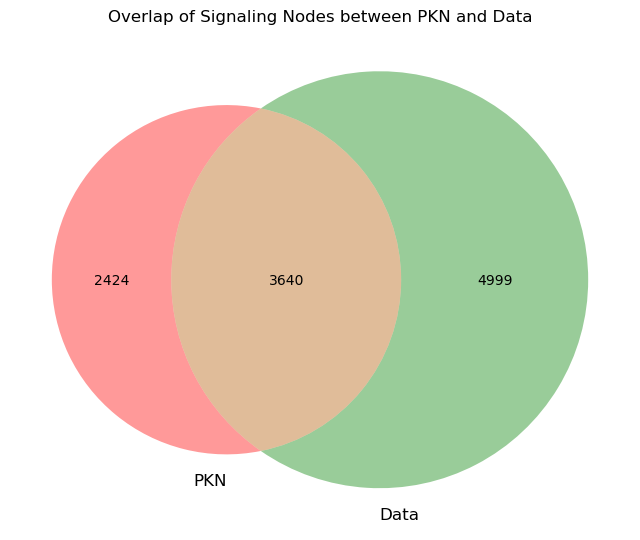

Filtered map_protein shape: (68690, 4)
Number of valid site_ids in filtered map_protein: 36049
Filtered phospho_data shape: (6572464, 6)


site_id,Cell_line,Drug,Dose,Time,AAK1:Q2M2I8:S18,AAK1:Q2M2I8:S20,AAK1:Q2M2I8:S21,AAK1:Q2M2I8:S618,AAK1:Q2M2I8:S623,AAK1:Q2M2I8:S624,...,ZYX:Q15942:S278,ZYX:Q15942:S281,ZYX:Q15942:S288,ZYX:Q15942:S308,ZYX:Q15942:S344,ZYX:Q15942:T179,ZYX:Q15942:T270,ZYX:Q15942:T274,ZYX:Q15942:T306,ZYX:Q15942:Y172
0,A431,Afatinib,0.0,30,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
1,A431,Afatinib,0.03,30,NaN,NaN,0.976147,1.022330,1.026487,1.024155,...,NaN,1.029377,NaN,NaN,1.064533,NaN,NaN,NaN,NaN,NaN
2,A431,Afatinib,0.3,30,NaN,NaN,1.051366,1.070668,1.013224,1.024089,...,NaN,1.041650,NaN,NaN,1.049898,NaN,NaN,NaN,NaN,NaN
3,A431,Afatinib,1.0,30,NaN,NaN,1.010975,1.005400,1.047740,1.021154,...,NaN,1.013295,NaN,NaN,1.031253,NaN,NaN,NaN,NaN,NaN
4,A431,Afatinib,3.0,30,NaN,NaN,1.069365,1.034893,1.051587,1.045287,...,NaN,0.921545,NaN,NaN,0.867421,NaN,NaN,NaN,NaN,NaN


In [11]:
combined_data = combined_df.rename(columns={
    "Modified sequence": "modified_peptide_sequence",
    "Gene names": "gene_id"
})

merged_data = pd.merge(combined_data, map_protein, 
                       on=["gene_id", "modified_peptide_sequence"],
                       how="inner")

phospho_data = merged_data[["site_id", "Cell_line", "Drug", "Dose", "Time", "Value"]].copy()

# Identify overlap with PKN and Filter map_protein to retain only proteins in the PKN
net = pd.read_csv('../data/pkn_signaling.tsv', sep='\t', index_col=False)
proteins_net = pd.concat([net['source'], net['target']], ignore_index=True).unique().tolist()
print("Number of unique proteins in net:", len(proteins_net))

proteins_map = map_protein['protein_id'].unique().tolist()
print("Number of unique protein_ids in map_protein:", len(proteins_map))

set_net = set(proteins_net)
set_map = set(proteins_map)

plt.figure(figsize=(8,8))
venn_diagram = venn2([set_net, set_map], set_labels=('PKN', 'Data'))
plt.title("Overlap of Signaling Nodes between PKN and Data")
plt.show()

map_protein_filtered = map_protein[map_protein['protein_id'].isin(set_net)]
print("Filtered map_protein shape:", map_protein_filtered.shape)

# Filter phospho_data based on valid site_ids from the filtered map_protein
valid_site_ids = map_protein_filtered['site_id'].unique().tolist()
print("Number of valid site_ids in filtered map_protein:", len(valid_site_ids))

phospho_data = phospho_data[phospho_data['site_id'].isin(valid_site_ids)]
print("Filtered phospho_data shape:", phospho_data.shape)

phospho_data["Time"] = phospho_data["Time"].astype(int)
phospho_data_wide = phospho_data.pivot_table(index=["Cell_line", "Drug", "Dose", "Time"], 
                                             columns="site_id", 
                                             values="Value").reset_index()

display(phospho_data_wide.head(5))

## Exploratory Data Analysis

First of all, we should check the missing value percentages across samples and across phosphosites.

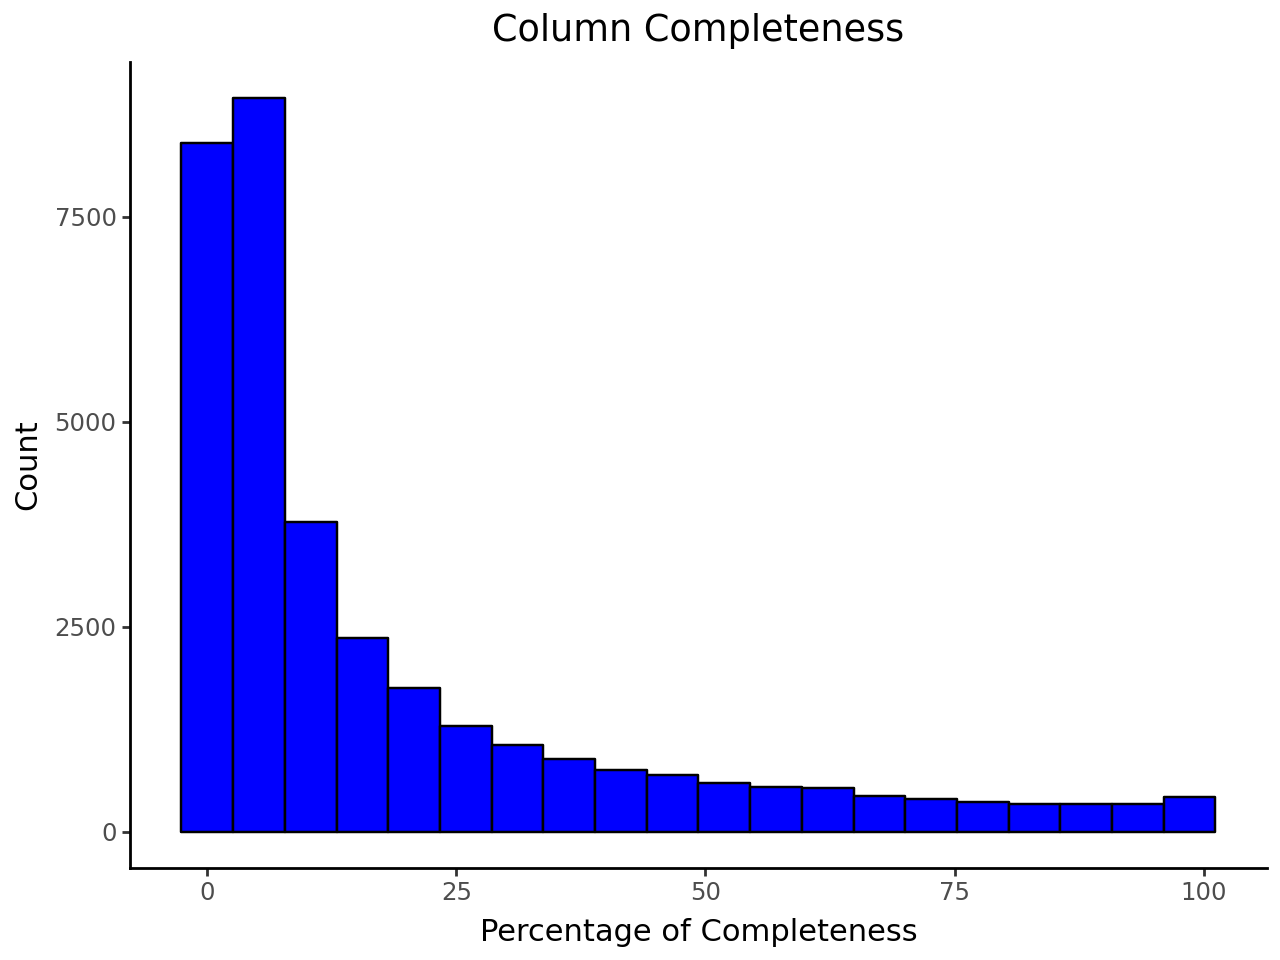

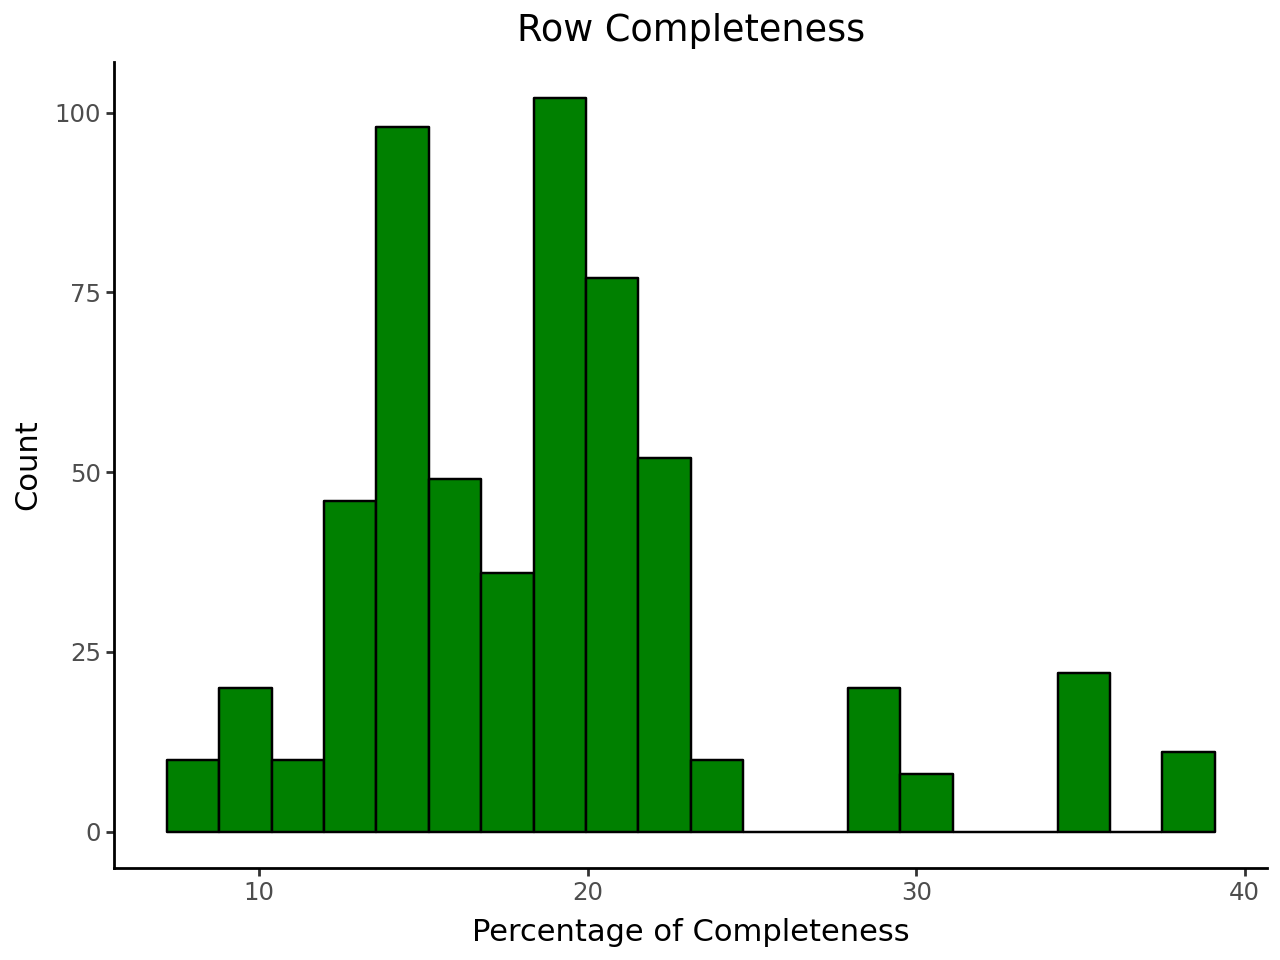

In [12]:
# Calculate the percentage of completeness across rows and columns (excluding Cell_line, Drug, and Time)
column_completeness = phospho_data_wide.drop(columns=['Cell_line', 'Drug', 'Time']).notna().mean() * 100
row_completeness = phospho_data_wide.drop(columns=['Cell_line', 'Drug', 'Time']).notna().mean(axis=1) * 100

column_completeness_df = pd.DataFrame({'Completeness': column_completeness})
row_completeness_df = pd.DataFrame({'Completeness': row_completeness})

# Histogram for column completeness
p1 = (p9.ggplot(column_completeness_df, p9.aes(x='Completeness')) +
      p9.geom_histogram(bins=20, fill='blue', color='black') +
      p9.labs(title='Column Completeness',
           x='Percentage of Completeness',
           y='Count') +
      p9.theme_classic())

# Histogram for row completeness
p2 = (p9.ggplot(row_completeness_df, p9.aes(x='Completeness')) +
      p9.geom_histogram(bins=20, fill='green', color='black') +
      p9.labs(title='Row Completeness',
           x='Percentage of Completeness',
           y='Count') +
      p9.theme_classic())

p1.show()
p2.show()

Plot relations between proteins, peptides and phosphosites.

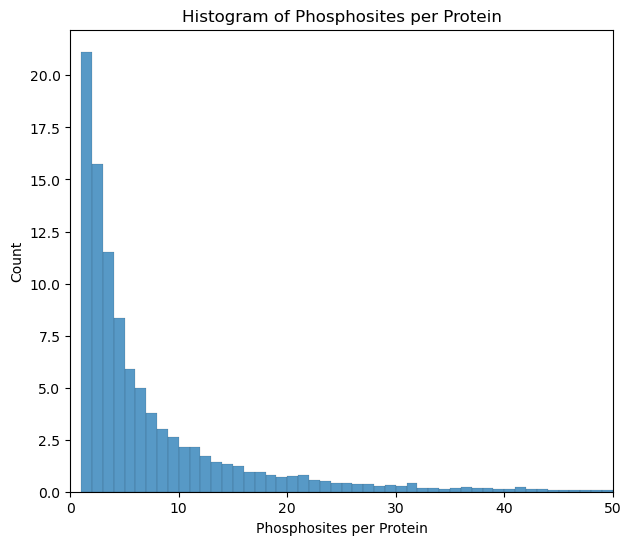

In [13]:
protein_aggregates = map_protein.groupby('protein_id').agg(
    phosphosites_per_protein=('site_id', 'nunique')
).reset_index()

# Plot histograms for peptides per protein and phosphosites per protein
plt.figure(figsize=(7, 6))
sns.histplot(protein_aggregates['phosphosites_per_protein'], binwidth=1, stat='percent')
plt.title('Histogram of Phosphosites per Protein')
plt.xlabel('Phosphosites per Protein')
plt.ylabel('Count')
plt.xlim(0, 50)

plt.show()

## Prepare Data for Modeling

Based on the phospho_data create the input datasets `X`, `X_drug` and `X_cell` as well as the target dataset `y`. Based on the map_protein create the nodes_sites_map dataset.

In [ ]:
drug_target = {
    'A485': ['Q09472', 'Q92793'],  # p300/CBP histone acetyltransferases
    'DMSO': [],  # inactive analog of A-485, negative control
    'AZD4547': ['P11362', 'P21802', 'P22607'],  # FGFR1, FGFR2, FGFR3
    'AZD8055': ['P42345'],  # mTOR
    'Afatinib': ['P00533', 'P04626', 'Q15303'],  # EGFR, ERBB2, ERBB4
    'BTZ-CFZ': ['P28074'],  # Proteasome subunit beta type-5 (PSMB5)
    'CFZ-BTZ': ['P28074'],  # Proteasome subunit beta type-5 (PSMB5)
    'CUDC101': ['P00533', 'P04626', 'Q13547', 'Q92769', 'O15379', 'Q9BY41', 'P56524', 'Q9UQL6', 'Q9UBN7', 'Q8WUI4', 'Q9UKV0', 'Q969S8'],  # EGFR, ERBB2, HDACs
    'Curcumin': [
        'P05067',  # Amyloid-beta precursor protein (APP)
        'P35228',  # Inducible nitric oxide synthase (iNOS or NOS2)
        'Q9ULX7',  # Carbonic anhydrase 14 (CA14)
        'P00915',  # Carbonic anhydrase 1 (CA1)
        'P45452',  # Collagenase 3 (MMP13)
        'Q9UBC3',  # DNA (cytosine-5)-methyltransferase 3B (DNMT3B)
        'P47989',  # Xanthine dehydrogenase/oxidase (XDH)
        'P23219',  # Prostaglandin G/H synthase 1 (PTGS1)
        'P14780',  # Matrix metalloproteinase-9 (MMP9)
        'P35354',  # Prostaglandin G/H synthase 2 (PTGS2)
        'P22748',  # Carbonic anhydrase 4 (CA4)
        'P00918',  # Carbonic anhydrase 2 (CA2)
        'O43570',  # Carbonic anhydrase 12 (CA12)
        'P23280',  # Carbonic anhydrase 6 (CA6)
        'Q16790',  # Carbonic anhydrase 9 (CA9)
        'P37231',  # Peroxisome proliferator-activated receptor gamma (PPARG)
        'P11473',  # Vitamin D3 receptor (VDR)
        'Q9Y490',  # Talin-1 (TLN1)
        'P15144',  # Aminopeptidase N (ANPEP)
        'P37840',  # Alpha-synuclein (SNCA)
        'Q9Y287',  # Integral membrane protein 2B (ITM2B)
    ],
    'Cytarabine': ['P09884'],  # DNA polymerase alpha catalytic subunit
    'Dactolisib': ['P42336', 'P42345'],  # PI3K, mTOR
    'Dasatinib': ['P00519', 'P12931'],  # BCR-ABL, SRC
    'Gefitinib': ['P00533'],  # EGFR
    'GeftinibAZD4547-1to80': ['P00533', 'P11362', 'P21802', 'P22607'],  # EGFR, FGFR1, FGFR2, FGFR3
    'Imatinib': ['P00519', 'P10721', 'P16234'],  # BCR-ABL, KIT, PDGFRA
    'Lapatinib': ['P00533', 'P04626'],  # EGFR, ERBB2
    'LapatinibAZD4547': ['P00533', 'P04626', 'P11362', 'P21802', 'P22607'],  # EGFR, ERBB2, FGFR1, FGFR2, FGFR3
    'MK2206': ['P31749', 'P31751', 'Q9Y243'],  # AKT1, AKT2, AKT3
    'Methotrexat': ['P00374'],  # Dihydrofolate reductase (DHFR)
    'Nintedanib': ['P17948', 'P35968', 'P35916', 'P11362', 'P21802', 'P22607', 'P16234', 'P09619'],  # VEGFR1, VEGFR2, VEGFR3, FGFR1, FGFR2, FGFR3, PDGFRs
    'PD325901': ['Q02750', 'P36507'],  # MEK1, MEK2
    'Paclitaxel': ['P07437'],  # Beta-tubulin
    'Pertuzumab': ['P04626'],  # ERBB2 (HER2/neu)
    'Pictilisib': ['P42336'],  # PI3K catalytic subunit alpha (PIK3CA)
    'Refametinib': ['Q02750', 'P36507'],  # MEK1, MEK2
    'Rituximab': ['P11836'],  # CD20 (MS4A1)
    'Romidepsin': ['Q13547', 'Q92769'],  # HDAC1, HDAC2
    'SAHA': ['Q13547', 'Q92769', 'O15379'],  # HDAC1, HDAC2, HDAC3
    'SHP099': ['Q06124'],  # SHP2 (PTPN11)
    'Selumetinib': ['Q02750', 'P36507'],  # MEK1, MEK2
    'SelumetinibMK2206-1to2': ['Q02750', 'P36507', 'P31749', 'P31751', 'Q9Y243'],  # MEK1, MEK2, AKT1, AKT2, AKT3
    'SelumetinibMK2206-3to1': ['Q02750', 'P36507', 'P31749', 'P31751', 'Q9Y243'],  # MEK1, MEK2, AKT1, AKT2, AKT3
    'Staursporin': ['P00533', 'P08631', 'P12931'],  # EGFR, PKC, SRC
    'Tideglusib': ['Q9H2K2'],  # GSK-3 beta
    'Trastuzumab': ['P04626'],  # ERBB2 (HER2/neu)
}

# Prepare X_data
unique_drug_cell_line = phospho_data[['Drug', 'Dose', 'Cell_line']].drop_duplicates().sort_values(by=['Drug', 'Dose', 'Cell_line'])
multiindex = pd.MultiIndex.from_frame(unique_drug_cell_line)
X_data = pd.DataFrame(index=multiindex)

unique_drugs = phospho_data['Drug'].unique()
for drug in unique_drugs:
    X_data[drug] = 0.0

for row in X_data.index:
    drug_, dose_, cell_line_ = row  # row is a tuple (Drug, Dose, Cell_line)
    if drug_ in X_data.columns:
        X_data.loc[row, drug_] = dose_

X_data.index = X_data.index.map(lambda x: f"{x[0]}-{round(float(x[1]))}_{x[2]}")
X_data.index.name = 'Drug_CL'

# Prepare X_drug
all_targets = sorted({target for targets in drug_target.values() for target in targets})
X_drug = pd.DataFrame(0, index=X_data.index, columns=all_targets)
for sample in X_drug.index:
    drug = sample.split('-')[0]
    if drug in drug_target:
        for target in drug_target[drug]:
            if target in X_drug.columns:
                X_drug.loc[sample, target] = 1

# Prepare X_cell
X_cell = pd.DataFrame(index=multiindex)
unique_cell_lines = phospho_data['Cell_line'].unique()
for cell_line in unique_cell_lines:
    X_cell[cell_line] = 0

for row in unique_drug_cell_line.itertuples(index=False):
    # row has (Drug, Dose, Cell_line)
    X_cell.loc[(row.Drug, row.Dose, row.Cell_line), row.Cell_line] = 1

# New index: Drug-Dose_CL
X_cell.index = X_cell.index.map(lambda x: f"{x[0]}-{round(float(x[1]))}_{x[2]}")
X_cell.index.name = 'Drug_CL'


# Prepare y_data
y_data = phospho_data.pivot_table(index=['Drug', 'Dose', 'Cell_line', 'Time'], columns='site_id', values='Value')
y_data.reset_index(inplace=True)
# Create a new column 'Drug-Dose_CL' by concatenating Drug and Dose (no separator)
y_data['Drug_CL'] = y_data.apply(lambda row: f"{row['Drug']}-{round(float(row['Dose']))}", axis=1)
# Create the new index in the format: Drug_CL_CL_Time
y_data['Drug_CL_Time'] = y_data['Drug_CL'] + "_" + y_data['Cell_line'] + "_" + y_data['Time'].astype(str)
y_data.set_index('Drug_CL_Time', inplace=True)
y_data.drop(columns=['Drug', 'Dose', 'Cell_line', 'Time', 'Drug_CL'], inplace=True)


# Prepare nodes_sites_map
unique_proteins = map_protein['protein_id'].unique()
unique_sites = map_protein['site_id'].unique()
nodes_sites_map = pd.DataFrame(0, index=unique_sites, columns=unique_proteins)
for _, row in map_protein.iterrows():
    site = row['site_id']
    protein = row['protein_id']
    if site in nodes_sites_map.index and protein in nodes_sites_map.columns:
        nodes_sites_map.loc[site, protein] = 1

# Sort and match index of nodes_sites_map with y_data
nodes_sites_map = nodes_sites_map.sort_index()
non_overlapping_values = set(nodes_sites_map.index).difference(y_data.columns)
nodes_sites_map = nodes_sites_map.drop(index=non_overlapping_values)

C:\Users\kanto\AppData\Local\Temp\ipykernel_20716\3583229559.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


Drug_CL
Rituximab-0_ARH-77          1
Rituximab-0_Ramos           1
Rituximab-0_SU-DHL-4        1
Rituximab-1000_ARH-77       1
Rituximab-1000_Ramos        1
Rituximab-1000_SU-DHL-4     1
Rituximab-30000_ARH-77      1
Rituximab-30000_Ramos       1
Rituximab-30000_SU-DHL-4    1
Name: P11836, dtype: int64

In [17]:
# Order Data
y_data = y_data[sorted(y_data.columns)]
temp = y_data.index.to_series().str.split('_', expand=True)
temp.columns = ['Drug', 'Cell_line', 'Time']
temp['Time'] = temp['Time'].astype(int)
y_data = y_data.loc[temp.sort_values(by=['Time','Drug','Cell_line']).index]

X_data = X_data.sort_index()
X_data = X_data[sorted(X_data.columns)]

X_cell = X_cell.sort_index()
X_cell = X_cell[sorted(X_cell.columns)]

X_drug = X_drug.sort_index()
X_drug = X_drug[sorted(X_drug.columns)]

nodes_sites_map = nodes_sites_map.sort_index()
nodes_sites_map = nodes_sites_map[sorted(nodes_sites_map.columns)]

display(X_data.head())
print(X_data.shape)

display(X_drug.head())
print(X_drug.shape)

display(X_cell.head())
print(X_cell.shape)

display(y_data.head())
print(y_data.shape)

display(nodes_sites_map.head())
print(nodes_sites_map.shape)

,A485,A486,AZD4547,AZD8055,Afatinib,BTZ-CFZ,CFZ-BTZ,CUDC101,Curcumin,Cytarabine,...,Rituximab,Romidepsin,SAHA,SHP099,Selumetinib,SelumetinibMK2206-1to2,SelumetinibMK2206-3to1,Staursporin,Tideglusib,Trastuzumab
Drug_CL,,,,,,,,,,,,,,,,,,,,,
A485-0_HeLa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A485-100000_HeLa,100000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A485-10000_HeLa,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A485-1000_HeLa,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A485-100_HeLa,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(460, 35)


,O15379,O43570,P00374,P00519,P00533,P00915,P00918,P04626,P05067,P07437,...,Q9BY41,Q9H2K2,Q9UBC3,Q9UBN7,Q9UKV0,Q9ULX7,Q9UQL6,Q9Y243,Q9Y287,Q9Y490
Drug_CL,,,,,,,,,,,,,,,,,,,,,
A485-0_HeLa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A485-100000_HeLa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A485-10000_HeLa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A485-1000_HeLa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A485-100_HeLa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(460, 62)


,A431,A459,A549,ARH-77,BT-474,HeLa,K562,KYSE-520,MDA-MB-175,PC-9,RPMI8226,Ramos,SK-BR-3,SU-DHL-4
Drug_CL,,,,,,,,,,,,,,
A485-0_HeLa,0,0,0,0,0,1,0,0,0,0,0,0,0,0
A485-100000_HeLa,0,0,0,0,0,1,0,0,0,0,0,0,0,0
A485-10000_HeLa,0,0,0,0,0,1,0,0,0,0,0,0,0,0
A485-1000_HeLa,0,0,0,0,0,1,0,0,0,0,0,0,0,0
A485-100_HeLa,0,0,0,0,0,1,0,0,0,0,0,0,0,0


(460, 14)


site_id,AAK1:Q2M2I8:S18,AAK1:Q2M2I8:S20,AAK1:Q2M2I8:S21,AAK1:Q2M2I8:S618,AAK1:Q2M2I8:S623,AAK1:Q2M2I8:S624,AAK1:Q2M2I8:S637,AAK1:Q2M2I8:S642,AAK1:Q2M2I8:S652,AAK1:Q2M2I8:S668,...,ZYX:Q15942:S278,ZYX:Q15942:S281,ZYX:Q15942:S288,ZYX:Q15942:S308,ZYX:Q15942:S344,ZYX:Q15942:T179,ZYX:Q15942:T270,ZYX:Q15942:T274,ZYX:Q15942:T306,ZYX:Q15942:Y172
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
Rituximab-0_ARH-77_1,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
Rituximab-0_Ramos_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rituximab-0_SU-DHL-4_1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
Rituximab-1000_ARH-77_1,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
Rituximab-1000_Ramos_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(665, 34190)


,A0A075B6I1,A0A087WUL8,A0A087X0R7,A0A0A0MS01,A0A0B4J1V2,A0A0B4J268,A0A0B4J2B6,A0A0C4DH38,A0A0U1RR23,A0AUZ9,...,Q9Y6X4,Q9Y6X6,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8,R4GMW8,S4R3N1,U3KQ54,V9GYD0
AAK1:Q2M2I8:S18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1:Q2M2I8:S20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1:Q2M2I8:S21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1:Q2M2I8:S618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1:Q2M2I8:S623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(34190, 8639)


## Export Data

In [18]:
y_data.to_csv('../data/decryptm_y.csv', index=True)
X_data.to_csv('../data/decryptm_x.csv', index=True)
X_cell.to_csv('../data/decryptm_xcell.csv', index=True)
X_drug.to_csv('../data/decryptm_xdrug.csv', index=True)
nodes_sites_map.to_csv('../data/decryptm_nodes_sites_map.csv', index=True)